# Optimizer Sanity Check: Does the Universe Work?

We have perfect omniscience: embeddings, gradients, momentum, and variance at every timestep. This notebook verifies that the Adam optimizer actually did what it was supposed to do.

For each token at each timestep, we'll:
1. Take the stored optimizer state (momentum, variance)
2. Compute what the Adam update *should* be
3. Predict where the token *should* move to
4. Compare to where it *actually* moved

If the universe is working correctly, the error should be zero (or floating-point epsilon). If we find anomalous movements, we've discovered something interesting.

## Mathematical Background

Adam optimizer update rule:

$$
\begin{align}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \quad \text{(bias correction)} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \quad \text{(bias correction)} \\
\Delta w &= -\alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} \\
w_{t+1} &= w_t + \Delta w - \lambda w_t \quad \text{(with weight decay)}
\end{align}
$$

Where:
- $g_t$ = gradient at time $t$
- $m_t$ = first moment (momentum)
- $v_t$ = second moment (variance)
- $\alpha$ = learning rate
- $\beta_1, \beta_2$ = exponential decay rates
- $\epsilon$ = numerical stability constant
- $\lambda$ = weight decay coefficient

## Parameters

In [24]:
TENSOR_PATH = '../tensors/Wordybird/1.12c_wordybird_1.safetensors'
EPSILON = 1e-8  # Adam numerical stability constant
RANDOM_SEED = 42

## Imports

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors import safe_open
from pathlib import Path

## Device Detection

In [26]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [27]:
# Load all tensors directly to device
with safe_open(TENSOR_PATH, framework='pt', device='cpu') as f:
    W = f.get_tensor('embeddings').to(device)      # [101, 50257, 64]
    grads = f.get_tensor('grads').to(device)       # [101, 50257, 64]
    momentum = f.get_tensor('momentum').to(device) # [101, 50257, 64]
    variance = f.get_tensor('variance').to(device) # [101, 50257, 64]
    
    # Hyperparameters (scalars)
    lr = f.get_tensor('learning_rate').item()
    beta1 = f.get_tensor('adam_beta1').item()
    beta2 = f.get_tensor('adam_beta2').item()
    wd = f.get_tensor('weight_decay').item()

print(f"Loaded embeddings: {W.shape}")
print(f"Hyperparameters: lr={lr}, β₁={beta1}, β₂={beta2}, weight_decay={wd}")

Loaded embeddings: torch.Size([101, 50257, 64])
Hyperparameters: lr=0.0010000000474974513, β₁=0.8999999761581421, β₂=0.9990000128746033, weight_decay=0.0


## Step 1: Verify Adam Updates

For each timestep $t \in [0, 99]$, we'll predict $w_{t+1}$ from the stored optimizer state and compare to the actual $w_{t+1}$.

In [28]:
# Storage for diagnostics
max_errors = []
mean_errors = []
median_errors = []

with torch.no_grad():
    for t in range(100):  # Predict steps 1 through 100 from steps 0 through 99
        # Bias correction terms (note: t+1 because Adam counts from 1)
        m_hat = momentum[t] / (1 - beta1**(t+1))
        v_hat = variance[t] / (1 - beta2**(t+1))
        
        # Adam update
        update = -lr * m_hat / (torch.sqrt(v_hat) + EPSILON)
        
        # Apply weight decay
        W_predicted = W[t] + update - wd * W[t]
        
        # Compute error
        error = torch.abs(W_predicted - W[t+1])
        
        max_err = error.max().item()
        mean_err = error.mean().item()
        median_err = error.median().item()
        
        max_errors.append(max_err)
        mean_errors.append(mean_err)
        median_errors.append(median_err)
        
        if t < 5 or t % 10 == 0:  # Print first few and every 10th
            print(f"Step {t:3d} → {t+1:3d}: max={max_err:.2e}, mean={mean_err:.2e}, median={median_err:.2e}")

# Summary statistics
max_errors = np.array(max_errors)
mean_errors = np.array(mean_errors)
median_errors = np.array(median_errors)

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Worst max error across all timesteps: {max_errors.max():.2e} (step {max_errors.argmax()})")
print(f"Typical max error: {np.median(max_errors):.2e}")
print(f"Typical mean error: {np.median(mean_errors):.2e}")
print(f"Typical median error: {np.median(median_errors):.2e}")

Step   0 →   1: max=1.22e-03, mean=9.73e-04, median=9.77e-04
Step   1 →   2: max=1.95e-03, mean=4.75e-04, median=2.37e-04
Step   2 →   3: max=1.71e-03, mean=2.15e-04, median=1.37e-04
Step   3 →   4: max=1.59e-03, mean=1.33e-04, median=1.07e-04
Step   4 →   5: max=1.46e-03, mean=9.68e-05, median=6.10e-05
Step  10 →  11: max=1.46e-03, mean=8.96e-05, median=8.39e-05
Step  20 →  21: max=1.71e-03, mean=1.85e-04, median=2.29e-04
Step  30 →  31: max=1.95e-03, mean=2.42e-04, median=2.44e-04
Step  40 →  41: max=1.95e-03, mean=2.69e-04, median=2.44e-04
Step  50 →  51: max=1.71e-03, mean=2.99e-04, median=2.90e-04
Step  60 →  61: max=1.95e-03, mean=3.01e-04, median=2.44e-04
Step  70 →  71: max=1.71e-03, mean=3.09e-04, median=2.44e-04
Step  80 →  81: max=1.71e-03, mean=3.70e-04, median=3.97e-04
Step  90 →  91: max=1.46e-03, mean=3.95e-04, median=4.88e-04

SUMMARY
Worst max error across all timesteps: 1.95e-03 (step 1)
Typical max error: 1.71e-03
Typical mean error: 2.99e-04
Typical median error: 2.

## Step 2: Visualize Error Distribution Over Time

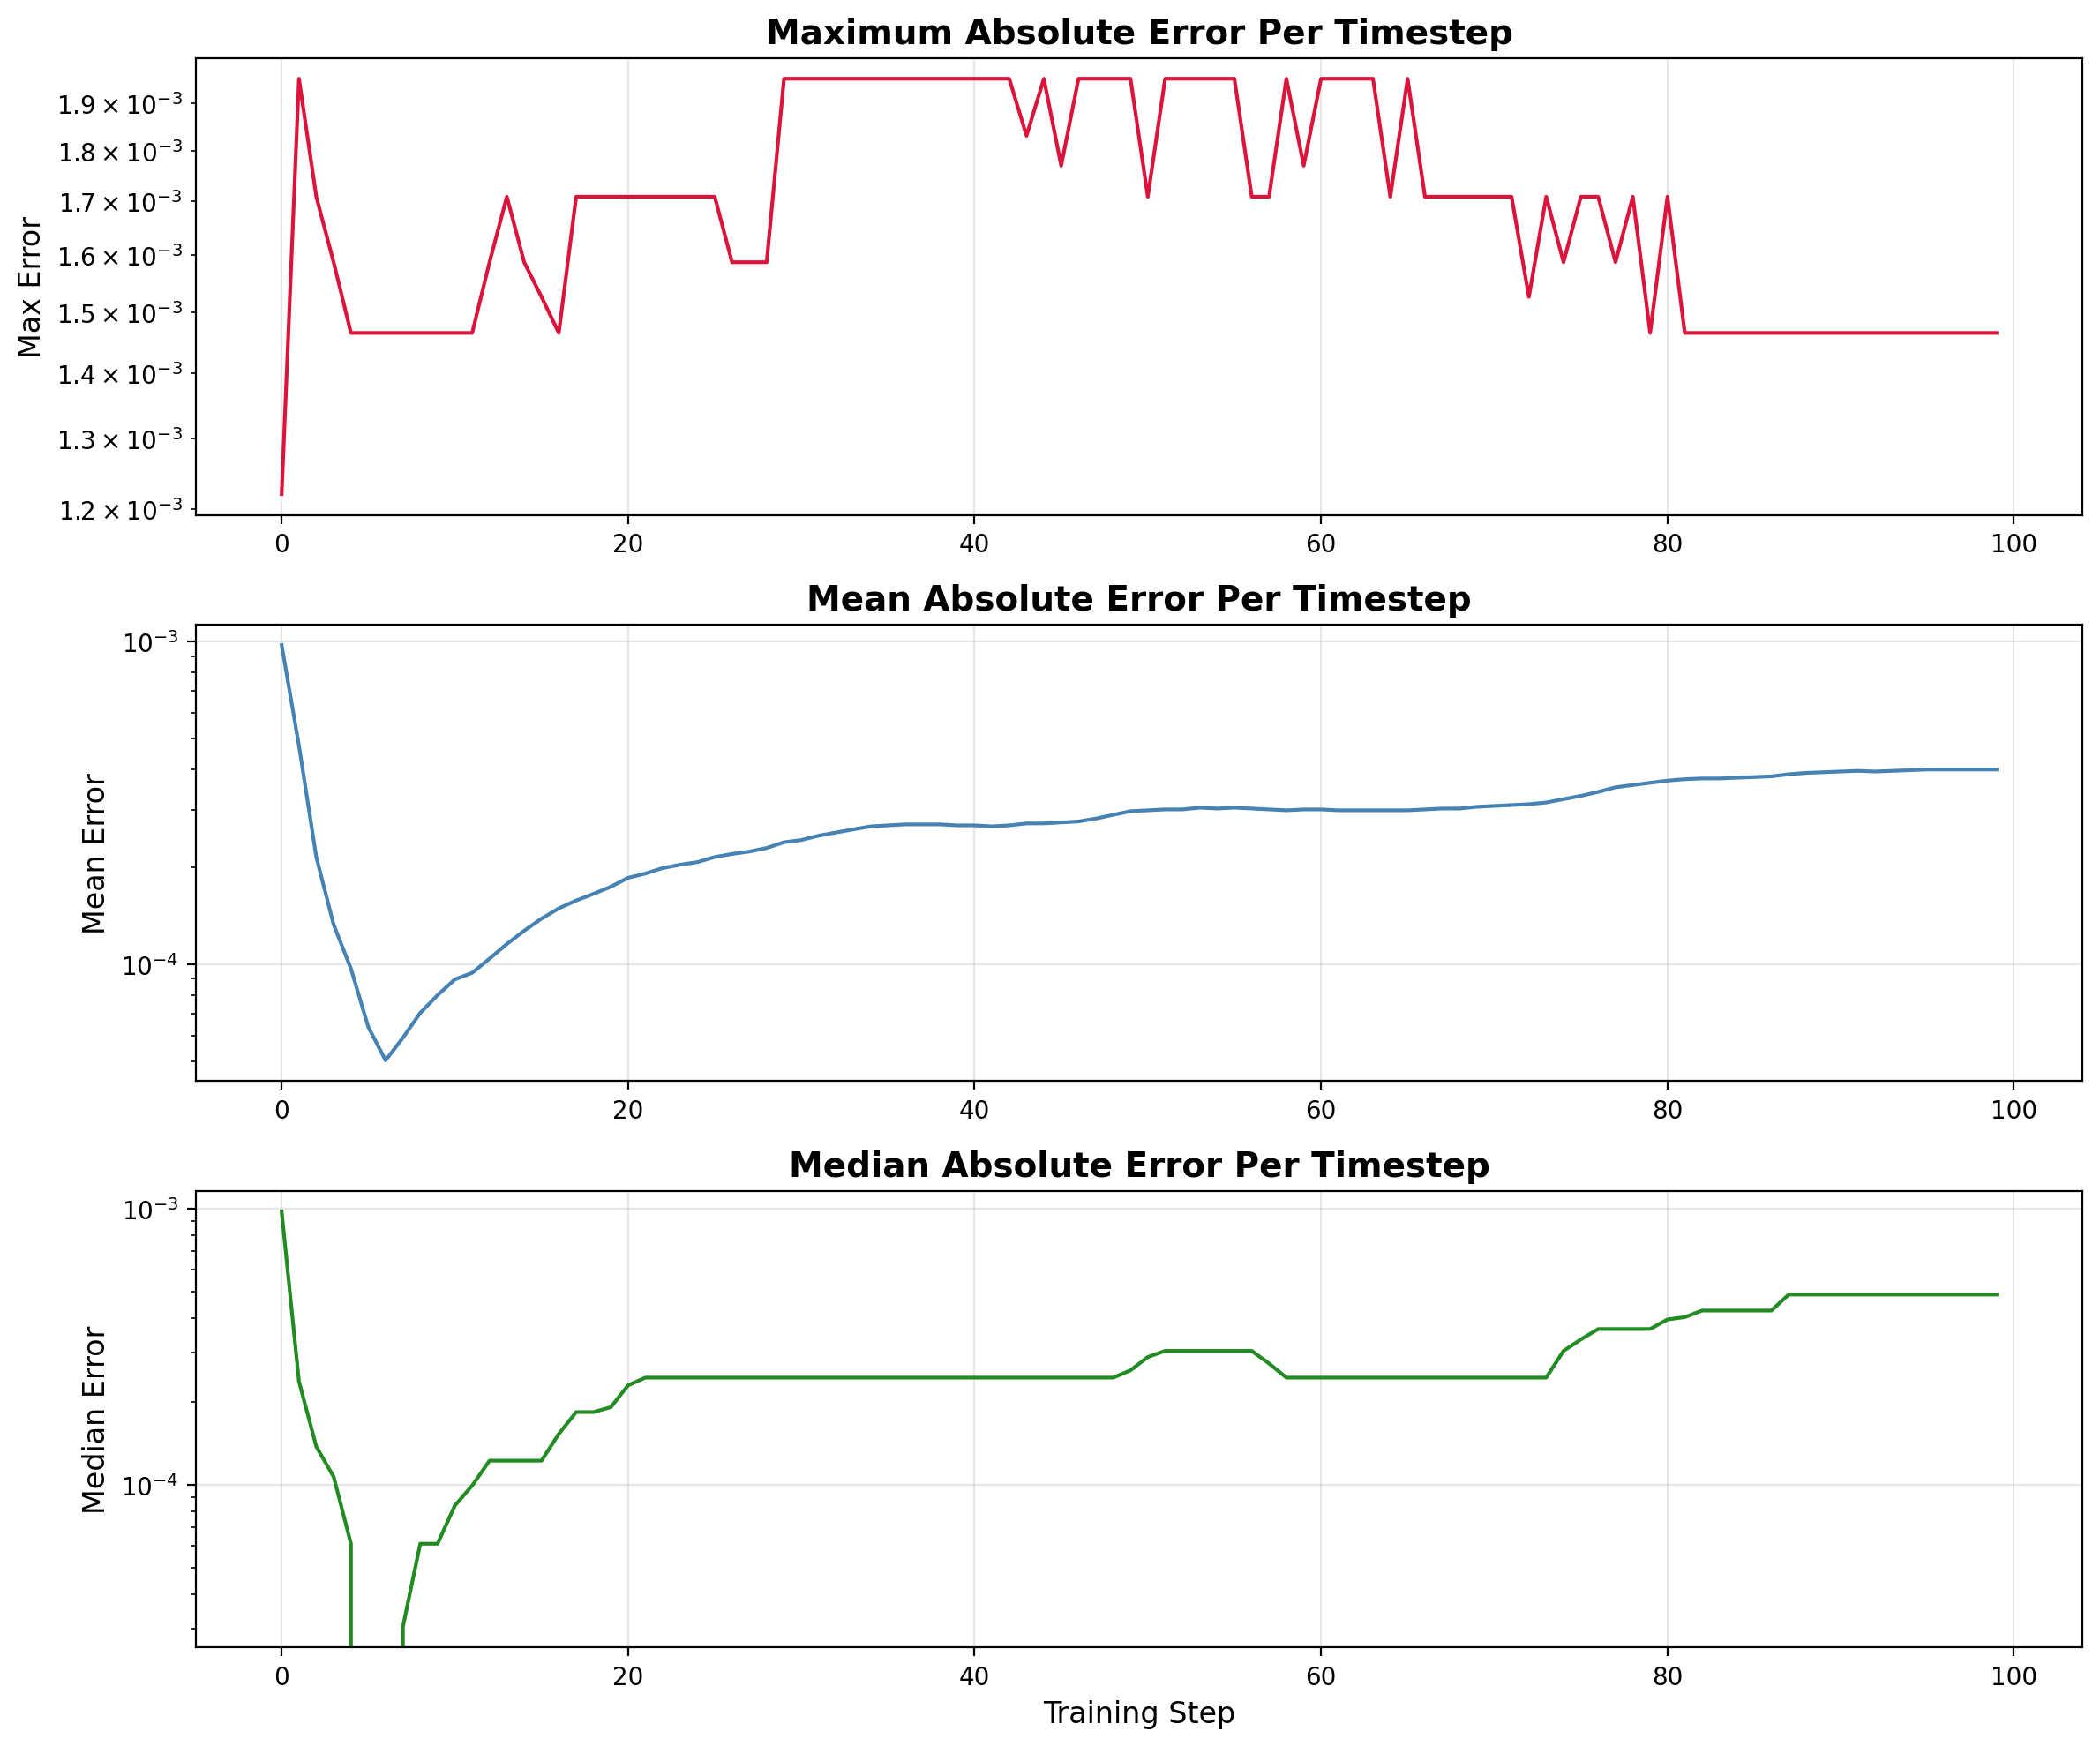

In [29]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), dpi=200)

steps = np.arange(100)

# Max error
axes[0].semilogy(steps, max_errors, color='crimson', linewidth=1.5)
axes[0].set_ylabel('Max Error', fontsize=12)
axes[0].set_title('Maximum Absolute Error Per Timestep', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Mean error
axes[1].semilogy(steps, mean_errors, color='steelblue', linewidth=1.5)
axes[1].set_ylabel('Mean Error', fontsize=12)
axes[1].set_title('Mean Absolute Error Per Timestep', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Median error
axes[2].semilogy(steps, median_errors, color='forestgreen', linewidth=1.5)
axes[2].set_ylabel('Median Error', fontsize=12)
axes[2].set_xlabel('Training Step', fontsize=12)
axes[2].set_title('Median Absolute Error Per Timestep', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 3: Find Worst Offenders

If there are anomalous movements, let's identify which tokens and which timesteps.

In [30]:
# Find the single worst error across all tokens and timesteps
with torch.no_grad():
    worst_errors = []
    
    for t in range(100):
        m_hat = momentum[t] / (1 - beta1**(t+1))
        v_hat = variance[t] / (1 - beta2**(t+1))
        update = -lr * m_hat / (torch.sqrt(v_hat) + EPSILON)
        W_predicted = W[t] + update - wd * W[t]
        error = torch.abs(W_predicted - W[t+1])
        
        # Find worst token at this timestep
        max_error_per_token = error.max(dim=1).values  # [50257]
        worst_token_idx = max_error_per_token.argmax().item()
        worst_error_value = max_error_per_token[worst_token_idx].item()
        
        worst_errors.append({
            'timestep': t,
            'token': worst_token_idx,
            'error': worst_error_value
        })

# Sort by error magnitude
worst_errors.sort(key=lambda x: x['error'], reverse=True)

print("Top 10 worst prediction errors:")
print("="*60)
for i, err in enumerate(worst_errors[:10], 1):
    print(f"{i:2d}. Timestep {err['timestep']:3d}, Token {err['token']:5d}: error = {err['error']:.2e}")

Top 10 worst prediction errors:
 1. Timestep   1, Token    79: error = 1.95e-03
 2. Timestep  29, Token 11230: error = 1.95e-03
 3. Timestep  30, Token 22215: error = 1.95e-03
 4. Timestep  31, Token 23159: error = 1.95e-03
 5. Timestep  32, Token 42724: error = 1.95e-03
 6. Timestep  33, Token 17584: error = 1.95e-03
 7. Timestep  34, Token  2530: error = 1.95e-03
 8. Timestep  35, Token  6531: error = 1.95e-03
 9. Timestep  36, Token  9994: error = 1.95e-03
10. Timestep  37, Token 11726: error = 1.95e-03


## Step 4: Detailed Analysis of Worst Case

Let's examine the worst offender in detail to understand what went wrong (if anything).

In [31]:
worst = worst_errors[0]
t = worst['timestep']
token_id = worst['token']

print(f"Analyzing Token {token_id} at timestep {t} → {t+1}")
print("="*60)

with torch.no_grad():
    # Extract this token's data (keep as tensors)
    w_t = W[t, token_id]
    w_t1_actual = W[t+1, token_id]
    grad_t = grads[t, token_id]
    m_t = momentum[t, token_id]
    v_t = variance[t, token_id]
    
    # Compute predicted update
    m_hat = m_t / (1 - beta1**(t+1))
    v_hat = v_t / (1 - beta2**(t+1))
    update = -lr * m_hat / (torch.sqrt(v_hat) + EPSILON)
    w_t1_predicted = w_t + update - wd * w_t
    
    error = torch.abs(w_t1_predicted - w_t1_actual)

print(f"Position at t={t}:     ||w|| = {torch.linalg.norm(w_t).item():.6f}")
print(f"Gradient at t={t}:     ||g|| = {torch.linalg.norm(grad_t).item():.6f}")
print(f"Momentum at t={t}:     ||m|| = {torch.linalg.norm(m_t).item():.6f}")
print(f"Variance at t={t}:     ||v|| = {torch.linalg.norm(v_t).item():.6f}")
print(f"\nPredicted update:      ||Δw|| = {torch.linalg.norm(update).item():.6f}")
print(f"Predicted position:    ||w|| = {torch.linalg.norm(w_t1_predicted).item():.6f}")
print(f"Actual position:       ||w|| = {torch.linalg.norm(w_t1_actual).item():.6f}")
print(f"\nPer-component error:   max = {error.max().item():.2e}, mean = {error.mean().item():.2e}")
print(f"Worst component:       dim {error.argmax().item()}, error = {error.max().item():.2e}")

Analyzing Token 79 at timestep 1 → 2
Position at t=1:     ||w|| = 0.190430
Gradient at t=1:     ||g|| = 0.000015
Momentum at t=1:     ||m|| = 0.000002
Variance at t=1:     ||v|| = 0.000000

Predicted update:      ||Δw|| = 0.005859
Predicted position:    ||w|| = 0.190430
Actual position:       ||w|| = 0.189453

Per-component error:   max = 1.95e-03, mean = 8.35e-04
Worst component:       dim 50, error = 1.95e-03


## Conclusion

If all errors are at floating-point precision (~1e-7 for float32, ~1e-3 for bfloat16), the universe is working correctly. If we see larger discrepancies, we've found something interesting—either a bug in the recording code, numerical instability, or genuine anomalous behavior.